# Odor bout rate and return point histogram Sleep paper

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stats
import scipy.stats as ss
from pylab import *
from scipy.optimize import curve_fit
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.stats import gaussian_kde
from scipy.stats import sem  # Import sem from scipy
from scipy.stats import ranksums

## Normalized bout histogram to plot return point

Data frame from Matlab

0. bout rate
1. fish number
2. bin number
3. preBout X position
4. preBout time in s


In [135]:
# change directory
bout_rates_ctrl=pd.read_csv(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\bout_rates_control.csv", header=None)
print(bout_rates_ctrl)

              0   1   2        3         4
0      0.997009   1   2  353.980    38.847
1      1.287001   1   2  353.298    40.080
2      1.795332   1   2  353.509    42.318
3      1.190476   1   2  353.935    43.234
4      0.269833   1   2  350.098    44.437
...         ...  ..  ..      ...       ...
30123  6.802721  27  46  888.591  1401.353
30124  0.955110  28  46  887.840   146.580
30125  4.545455  28  46  888.808   319.419
30126  1.064963  28  46  888.963   319.757
30127  9.174312  28  46  888.200   340.804

[30128 rows x 5 columns]


In [136]:
# change directory
bout_rates_SD=pd.read_csv(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\bout_rates_starved.csv", header=None)
print(bout_rates_SD)

              0   1   2        3        4
0      0.882613  24   1  341.647   12.394
1      0.662252   1   2  354.522  142.629
2      0.753012   1   2  353.623  144.539
3      1.992032   1   2  353.696  159.972
4      0.660939   1   2  354.687  160.961
...         ...  ..  ..      ...      ...
31815  7.462687  25  46  889.214  276.645
31816  2.375297  26  46  888.231  555.205
31817  2.188184  27  46  889.250  107.147
31818  1.196172  27  46  888.935  108.031
31819  1.116071  27  46  888.567  210.060

[31820 rows x 5 columns]


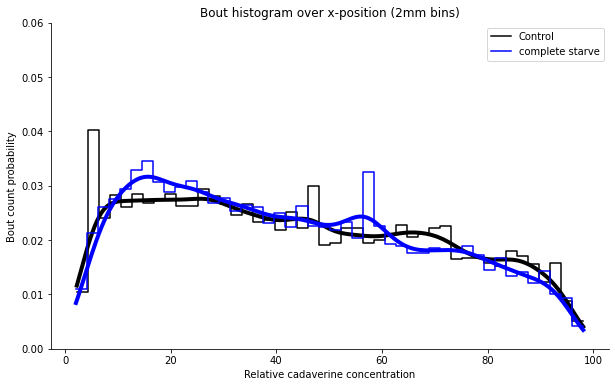

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data1 and data2 are pandas DataFrames
data1 = bout_rates_ctrl
data2 = bout_rates_SD

#convert x values to relative values for cadaverine concentration
preBout_1 = data1[3]
preBout_2=data2[3]
x_min = 330
x_max = 900
normalized_preBout_1 = (preBout_1 - x_min) / (x_max - x_min) * 100
normalized_preBout_2 = (preBout_2 - x_min) / (x_max - x_min) * 100;

# Create a figure
plt.figure(figsize=(10, 6))

# Plot both histograms using histplot ; previously bins: 85, 46bins =2mm per bin
sns.histplot(data=data1, x=normalized_preBout_1, kde=True, bins=46,  color='black',element="step", fill=False, 
             label='Control',stat='probability',
            line_kws = dict(linewidth = 4))
sns.histplot(data=data2, x=normalized_preBout_2, kde=True, bins=46, color='blue',element="step", fill=False,
             label='complete starve',stat='probability',
              line_kws = dict(linewidth = 4))

# Add labels and title
plt.ylabel("Bout count probability")
plt.xlabel("Relative cadaverine concentration")
plt.title("Bout histogram over x-position (2mm bins)")

plt.ylim(0.0, 0.06)
# Add a legend to distinguish the two distributions
plt.legend()

# Remove the top and right spines for a cleaner look
sns.despine(right=True, bottom=False)

# Save or display the plot
plt.savefig(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\return_point.pdf")
plt.show()


## Bout rates

bout rate difference calculated by substracting the bout rate 2cm close to odor source from the br far away from odor source.

bout rate = sum time/bout count *60

In [138]:
bout_rates_ctrl['bout_count'] = bout_rates_ctrl.index
print(bout_rates_ctrl)
bout_rates_SD['bout_count'] = bout_rates_SD.index
print(bout_rates_SD)

              0   1   2        3         4  bout_count
0      0.997009   1   2  353.980    38.847           0
1      1.287001   1   2  353.298    40.080           1
2      1.795332   1   2  353.509    42.318           2
3      1.190476   1   2  353.935    43.234           3
4      0.269833   1   2  350.098    44.437           4
...         ...  ..  ..      ...       ...         ...
30123  6.802721  27  46  888.591  1401.353       30123
30124  0.955110  28  46  887.840   146.580       30124
30125  4.545455  28  46  888.808   319.419       30125
30126  1.064963  28  46  888.963   319.757       30126
30127  9.174312  28  46  888.200   340.804       30127

[30128 rows x 6 columns]
              0   1   2        3        4  bout_count
0      0.882613  24   1  341.647   12.394           0
1      0.662252   1   2  354.522  142.629           1
2      0.753012   1   2  353.623  144.539           2
3      1.992032   1   2  353.696  159.972           3
4      0.660939   1   2  354.687  160.961   

In [139]:
# Assume bout_rates_ctrl is your original DataFrame
# Rename columns for clarity
bout_rates_ctrl.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time', 'bout_count']

#convert prebout times from seconds to minutes
bout_rates_ctrl['prebout_time_minutes'] = bout_rates_ctrl['prebout_time'] / 60
#print(bout_rates_ctrl)

# Define the cutoff for leftmost and rightmost bins
#leftmost_bins = range(0, 20)
#rightmost_bins = range(65,85)

leftmost_bins = range(0, 10)
rightmost_bins = range(36,46)

# Separate data for leftmost and rightmost bins
left_bins_df_ctrl = bout_rates_ctrl[bout_rates_ctrl['bin_number'].isin(leftmost_bins)]
right_bins_df_ctrl = bout_rates_ctrl[bout_rates_ctrl['bin_number'].isin(rightmost_bins)]

# Calculate bout rate for left and right bins per fish
# Group by fish_number, calculate total bout_count and total time for each side, then compute bout rate
left_bout_rates_ctrl = left_bins_df_ctrl.groupby('fish_number').apply(lambda x: len(x['bout_count']) / 30).reset_index()
left_bout_rates_ctrl.columns = ['fish_number', 'bout_rate_left']  # Rename columns after reset_index
#print(left_bout_rates_ctrl)

right_bout_rates_ctrl = right_bins_df_ctrl.groupby('fish_number').apply(lambda x: len(x['bout_count']) / 30).reset_index()
right_bout_rates_ctrl.columns = ['fish_number', 'bout_rate_right']  # Rename columns after reset_index

#remove bout rates above 200 bouts/min as they are unrealistic
#left_bout_rates_ctrl = left_bout_rates_ctrl[left_bout_rates_ctrl['bout_rate_left'] <= 200]
#right_bout_rates_ctrl = right_bout_rates_ctrl[right_bout_rates_ctrl['bout_rate_right'] <= 200]

# Merge left and right bout rates for each fish
bout_rate_df_ctrl = pd.merge(left_bout_rates_ctrl, right_bout_rates_ctrl, on='fish_number')

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_ctrl['bout_rate_difference'] = bout_rate_df_ctrl['bout_rate_right'] - bout_rate_df_ctrl['bout_rate_left']
print(bout_rate_df_ctrl)

# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_ctrl = bout_rate_df_ctrl['bout_rate_difference'].mean()
sem_bout_rate_difference_ctrl = sem(bout_rate_df_ctrl['bout_rate_difference'])


    fish_number  bout_rate_left  bout_rate_right  bout_rate_difference
0             2       13.066667         1.766667            -11.300000
1             3        7.000000         0.500000             -6.500000
2             5        4.500000         4.233333             -0.266667
3             6        5.766667         4.300000             -1.466667
4             7        0.200000         2.533333              2.333333
5             8        0.333333         7.266667              6.933333
6             9       23.133333         8.800000            -14.333333
7            10        8.300000         5.466667             -2.833333
8            11        6.066667         6.500000              0.433333
9            12        8.566667         0.633333             -7.933333
10           13        5.966667         8.466667              2.500000
11           14        4.566667        10.433333              5.866667
12           15        3.400000         5.466667              2.066667
13    

In [140]:
# Assume bout_rates_ctrl is your original DataFrame
# Rename columns for clarity
bout_rates_SD.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time', 'bout_count']
#convert prebout times from seconds to minutes
bout_rates_SD['prebout_time_minutes'] = bout_rates_SD['prebout_time'] / 60
#print(bout_rates_SD)


# Define the cutoff for leftmost and rightmost bins
#leftmost_bins = range(0, 20)
#rightmost_bins = range(65,85)
leftmost_bins = range(0, 10)
rightmost_bins = range(36,46)

# Separate data for leftmost and rightmost bins
left_bins_df_SD = bout_rates_SD[bout_rates_SD['bin_number'].isin(leftmost_bins)]
#print(left_bins_df_SD)
right_bins_df_SD = bout_rates_SD[bout_rates_SD['bin_number'].isin(rightmost_bins)]

# Calculate bout rate for left and right bins per fish
# Group by fish_number, calculate total bout_count and total time for each side, then compute bout rate
left_bout_rates_SD = left_bins_df_SD.groupby('fish_number').apply(lambda x: len(x['bout_count']) /30).reset_index()
print(left_bout_rates_SD)
left_bout_rates_SD.columns = ['fish_number', 'bout_rate_left']  # Rename columns after reset_index


right_bout_rates_SD = right_bins_df_SD.groupby('fish_number').apply(lambda x: len(x['bout_count']) / 30).reset_index()
right_bout_rates_SD.columns = ['fish_number', 'bout_rate_right']  # Rename columns after reset_index

#remove bout rates above 200 bouts/min as they are unrealistic
#left_bout_rates_ctrl = left_bout_rates_ctrl[left_bout_rates_ctrl['bout_rate_left'] <= 200]
#right_bout_rates_ctrl = right_bout_rates_ctrl[right_bout_rates_ctrl['bout_rate_right'] <= 200]


# Merge left and right bout rates for each fish
bout_rate_df_SD = pd.merge(left_bout_rates_SD, right_bout_rates_SD, on='fish_number')

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_SD['bout_rate_difference'] = bout_rate_df_SD['bout_rate_right'] - bout_rate_df_SD['bout_rate_left']


# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_SD = bout_rate_df_SD['bout_rate_difference'].mean()
sem_bout_rate_difference_SD = sem(bout_rate_df_SD['bout_rate_difference'])


    fish_number          0
0             1  13.200000
1             2   6.100000
2             3  11.133333
3             4  21.000000
4             5  13.200000
5             6   7.266667
6             7   8.800000
7             8   1.700000
8             9   8.133333
9            10   8.866667
10           11  14.666667
11           12  13.500000
12           13  11.400000
13           14   1.266667
14           15  12.466667
15           16   5.833333
16           17   6.966667
17           18   2.800000
18           19   5.466667
19           20  13.800000
20           21  15.400000
21           22  10.100000
22           23   0.633333
23           24   3.633333
24           25   7.100000
25           26   3.866667
26           27   6.166667
27           28   5.100000


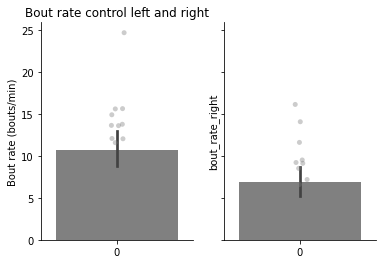

In [101]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_bout_rates_ctrl['bout_rate_left'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax1,data=left_bout_rates_ctrl['bout_rate_left'], dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_bout_rates_ctrl['bout_rate_right'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax2,data=right_bout_rates_ctrl['bout_rate_right'], dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate control left and right")
#ax.set_ylim(0, 65)
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
fig.savefig(r"E:\Olfaction\Preference_index_cortisol\100ng_cortisol_15min\bout_rate_left_right_control.pdf")

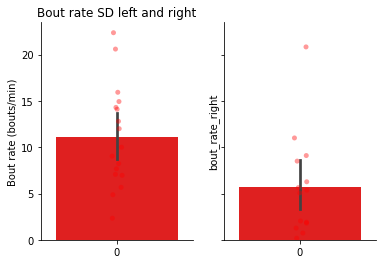

In [102]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_bout_rates_SD['bout_rate_left'], color = "red", orient="v")
ax = sns.stripplot(ax=ax1,data=left_bout_rates_SD['bout_rate_left'], dodge=True, color="red", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_bout_rates_SD['bout_rate_right'], color = "red", orient="v")
ax = sns.stripplot(ax=ax2,data=right_bout_rates_SD['bout_rate_right'], dodge=True, color="red", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate SD left and right")
#ax.set_ylim(0, 65)
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
fig.savefig(r"E:\Olfaction\Preference_index_cortisol\100ng_cortisol_15min\bout_rate_left_right_cortisol.pdf")

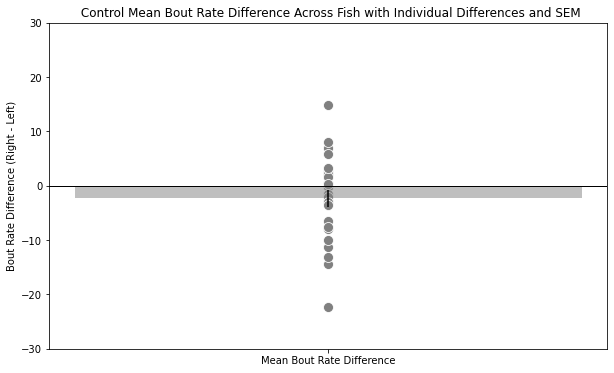

In [141]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot: Mean bout rate difference across all fish with error bar for SEM
ax=sns.barplot(x=['Mean Bout Rate Difference'], y=[mean_bout_rate_difference_ctrl], color='grey', yerr=sem_bout_rate_difference_ctrl, alpha=0.5)

# Scatter plot overlay: Individual bout rate differences per fish
ax=sns.scatterplot(x=['Mean Bout Rate Difference'] * len(bout_rate_df_ctrl), y=bout_rate_df_ctrl['bout_rate_difference'], color='grey', s=100)

# Labels and title
plt.ylabel("Bout Rate Difference (Right - Left)")
plt.title(" Control Mean Bout Rate Difference Across Fish with Individual Differences and SEM")

plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')  # Dashed line at y=0

plt.savefig(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\boutrateDiff_ctrl.pdf")
plt.show()

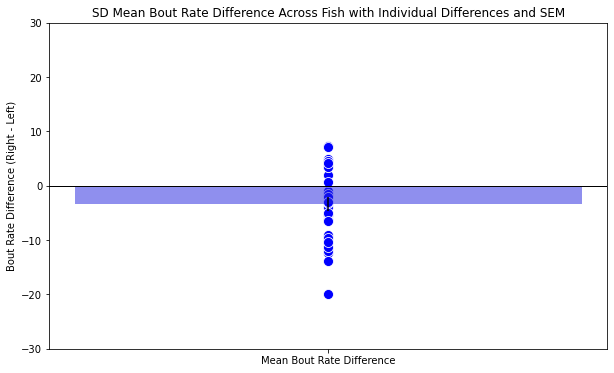

In [142]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot: Mean bout rate difference across all fish with error bar for SEM

sns.barplot(x=['Mean Bout Rate Difference'], y=[mean_bout_rate_difference_SD], color='blue', yerr=sem_bout_rate_difference_SD, alpha=0.5)

# Scatter plot overlay: Individual bout rate differences per fish

sns.scatterplot(x=['Mean Bout Rate Difference'] * len(bout_rate_df_SD), y=bout_rate_df_SD['bout_rate_difference'], color='blue', s=100)

# Labels and title
plt.ylabel("Bout Rate Difference (Right - Left)")
plt.title("SD Mean Bout Rate Difference Across Fish with Individual Differences and SEM")

plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')  # Dashed line at y=0

plt.savefig(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\boutrateDiff_cortisol.pdf")
plt.show()

In [143]:
# independent t-test
#control vs treatment
#p = ss.ttest_ind(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'], equal_var=False)
#print("control vs treatment:", p)

p=ranksums(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'])
print("control vs treatment:", p)

control vs treatment: RanksumsResult(statistic=0.42761798705987897, pvalue=0.6689292682527673)


In [144]:
# independent t-test
#control vs treatment
p = ss.ttest_ind(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'], equal_var=False)
print("control vs treatment:", p)

control vs treatment: TtestResult(statistic=0.4945067995873321, pvalue=0.623189816964614, df=48.306886038156705)
